# REEU-23-06-30 CAN BUS J1939 Data Wrangling Session
### By Fabio A. Castiblanco, based on Dr. Yang Wang's CAN BUS Reverse Engineering and Parsing code.

## What is a "CAN BUS"?

A **Controller Area Network** (CAN bus) is a vehicle bus standard designed to **allow microcontrollers and devices to communicate with each other's** applications without a host computer. It is a message-based protocol, designed originally for multiplex electrical **wiring within automobiles** to save on copper, but it can also be used in many other contexts. For each device, the data in a frame is transmitted serially but in such a way that if more than one device transmits at the same time, the highest priority device can continue while the others back off. Frames are received by all devices, including by the transmitting device. (Source: Wikipedia.org)

In a nutshell, is a communications bus for vehicle sensors and systems (aka. ECUs)

## Know your Data: J1939 & CAN

### What is the J1939 Standard?

Society of Automotive Engineers standard **SAE J1939** is the vehicle bus recommended practice used for communication and diagnostics among vehicle components. Originating in the car and heavy-duty truck industry in the United States, it is now widely used in other parts of the world. SAE J1939 is **used in the commercial vehicle area for connection and communication throughout the vehicle**, with the physical layer defined in **ISO 11898 (aka. CAN)**. A different physical layer is used between the tractor and trailer, specified in ISO 11992. (Lightly edited from Wikipedia.org)

### J1939 Messages

A J1939 message contains two important fields: 

* PGN: Parameter Group Number, also known as Message ID, contain information about sender, topic, and priority. PGNs are sent 
* SPN: Suspect Parameter Numbers contain the "data payload". Payloads can contain various parameters (or signals) associated to a single PGN

<img src=img/j1939-msg.png width="683" height="90">

*The structure of a J1939 Message*

<img src=img/j1939-can-sample.png width="530" height="166">

*J1939 message samples recorded from a Corn Harvester in the 2021 Harvest Season in NE. Lots of Hexadecimal numbers! (Courtesy of Stevens Farms, NE)*

### J1939 Messages: Parameter Group Numbers

PGNs point to vehicle signals and parameters which are defined as Parameter Groups

<img src=img/j1939-pgn.png width="837" height="99">

* A paramater group can be "engine temperature", which contains signals related to the temperature of several components on the engine, such as coolant temperature, fuel temperature, oil temperature, etc.
* PGNs are numbers that can range from 0 - 65279 (0-FEFF in hexadecimal)
* In J1939 there are **hundreds** of definitions for parameter numbers

### J1939 Messages: Suspect Parameter Numbers

SPNs are numbers assigned by the SAE to a specific parameter within a parameter group.

<img src=img/j1939-spn.png width="697" height="225">

* SPNs contained within a parameter group share common characteristics (**a context**)
* Data payloads contain several SPNs

## Machine Data Wrangling with Pandas
Now that we know more about our dataset, let's dive in and do some wrangling! We are going to work with a small data log recorded from a John Deere 320D skid-steer machine using an ISOBlue edge-computer. Data was recorded during the CAN BUS session of the Spring 2022 session of the ASM345 (Power Units and Power Trains) course at Purdue. It contains all sorts of data from machine sensors (some unknown to people... outside OEMs). For this exercise, we are going to use **Python, Numpy, Matplotlib, and Pandas**

In [1]:
## Data processing libraries imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates

Make sure you have pytables installed before running this notebook. If you don't have it, just run *python3 -m pip install tables* in your computer's commandline.

First we start declaring the dataset's metadata (file path, event, machine under test, and date). The metadata will allow us to easily locate the file in case of analyzing multiple experiments/events.

In [2]:
## Declare raw log path 

DATA_PATH = 'data/'

## Declare event, machine, and date from log

EVENT = 'asm345'
MACHINE_ID = 'j320d'
DATE = '04132022'

## Generate filename based on experiment event, machine ID and date

CSV_NAME = '-'.join([EVENT, MACHINE_ID, DATE, 'tra.csv'])

Time to read our data from our dataset file. Use pandas to read data from our CSV file. **Hint:** The Path and the CSV name will give you the full path

In [3]:
can_log = pd.read_csv(DATA_PATH + CSV_NAME)
can_log.head()

,time,can_interface,can_id,can_data
0,2022-04-13 14:06:30.397088+00,can0,0CF00300,FF0000FFFFFFFFFF
1,2022-04-13 14:06:30.391976+00,can0,18FEE917,FFFF0000FFFFFFFF
2,2022-04-13 14:06:30.391423+00,can0,18FEE817,0201200100020006
3,2022-04-13 14:06:30.391258+00,can0,18FFA617,FF00FF00FF0840FF
4,2022-04-13 14:06:30.390209+00,can0,18FFFA17,0001F0FCFFFFFFFF


It's always a good idea to declare the data type of each column of our data set before beginning our analysis. We do it with a Python dictionary.

In [4]:
dtypes = {
    'time': str, \
    'can_interface': str, \
    'can_id': str, \
    'can_data': str}

In [5]:
cols = list(dtypes.keys()) ## Parse our dictionary to a list containing the name of our columns

In [6]:
datetime_col = [cols[0]] ## Select the first column as our time index

In [7]:
type(can_log['time'][0]) ## Check the data type of the rows in the 'time' column

str

### How big is our data set?  

It's always a good practice to look at the dimension of the data we are going to work on. That allows us to tell what we can and can't do (in terms of efficient computing).
Use pandas to return the number of rows in our dataframe

In [8]:
print(len(can_log))

109000


### Data clean up

Data sets can have hundreds of thousands of rows, but some of them are invalid entries. It is always good to discard those invalid entries before performing any operation on the data set. Use Pandas to discard rows with invalid timestamps (entries in the 'time' column)

In [9]:
# Discard rows when `ts` is nan
can_log.dropna(subset=['time'], inplace=True)

### Timestamps and time zones
For clarity, most data collection systems and loggers use UTC (Universal Time Coordinated) timestamps. This avoids confusions due to ambiguous timezones, dayligth savings time. Though, it is hard to correlate with our clocks, which follow a timezone. We can use Pandas to change the timezone of our dataframe timestamps. Create a new column with name **ts_corr** for our corrected timestamps.

**Hint:** Use Pandas *.apply()* and an embedded **lambda** function to apply the change to all the rows of the dataframe. 

* https://www.dataquest.io/blog/tutorial-lambda-functions-in-python/
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html

In [10]:
# Convert UTC timestamp to local time zone
can_log['ts_corr'] = can_log['time'].apply(lambda x: pd.Timestamp(x, tz='UTC').tz_convert(tz='America/New_York'))

Check again the dataframe to verify our operation above was correct.

In [11]:
can_log.head()

,time,can_interface,can_id,can_data,ts_corr
0,2022-04-13 14:06:30.397088+00,can0,0CF00300,FF0000FFFFFFFFFF,2022-04-13 10:06:30.397088-04:00
1,2022-04-13 14:06:30.391976+00,can0,18FEE917,FFFF0000FFFFFFFF,2022-04-13 10:06:30.391976-04:00
2,2022-04-13 14:06:30.391423+00,can0,18FEE817,0201200100020006,2022-04-13 10:06:30.391423-04:00
3,2022-04-13 14:06:30.391258+00,can0,18FFA617,FF00FF00FF0840FF,2022-04-13 10:06:30.391258-04:00
4,2022-04-13 14:06:30.390209+00,can0,18FFFA17,0001F0FCFFFFFFFF,2022-04-13 10:06:30.390209-04:00


**Remember:** We are working with **time series data**, which means that data points are **indexed in time order**. Use Pandas to set the corrected timestamps (**ts_corr**) as the dataframe index, and discard the unnecesary columns of the data set. Also, it is a good idea to give columns more intuitive names, based on context. Use Pandas to give better names to the columns of the data set. 

In [12]:
# Assign timezone corrected timestamps as indices
can_log = can_log.set_index('ts_corr')
can_log = can_log.drop(columns=['time', 'can_interface'])
idx = can_log.index
idx.rename('ts', inplace=True)
can_log.rename(columns={'can_data' : 'payload'}, inplace=True)

Check again the contents of your data frame.

In [13]:
can_log.head()

,can_id,payload
ts,,
2022-04-13 10:06:30.397088-04:00,0CF00300,FF0000FFFFFFFFFF
2022-04-13 10:06:30.391976-04:00,18FEE917,FFFF0000FFFFFFFF
2022-04-13 10:06:30.391423-04:00,18FEE817,0201200100020006
2022-04-13 10:06:30.391258-04:00,18FFA617,FF00FF00FF0840FF
2022-04-13 10:06:30.390209-04:00,18FFFA17,0001F0FCFFFFFFFF


Now that we have a cleaner dataframe, it is time to start working on our data. Below you will find a helper function: **parse_canid(can_id)**. This function will extract the PGNs (Parameter Group Number), SA (Source Address), DA (Destination Address), and PRIO (Priority) of the recorded messages in our log from the **can_id** column. It takes a 4-byte **hexadecimal** number as input and returns 4 elements, each one a **decimal** number representing the PGN, SA, DA, and PRIO embedded in the CAN ID. 

**Some useful readings:**
* https://en.wikipedia.org/wiki/Hexadecimal
* https://en.wikipedia.org/wiki/Byte


In [17]:
# ISOBUS message masks
MASK_2_BIT = ((1 << 2) - 1)
MASK_3_BIT = ((1 << 3) - 1)
MASK_8_BIT = ((1 << 8) - 1)

def parse_canid(can_id):
    # J1939 header info:
    # http://www.ni.com/example/31215/en/
    # http://tucrrc.utulsa.edu/J1939_files/HeaderStructure.jpg
    if can_id is None:
        return [-1] * 4
    
    header = int(can_id, 16)

    sa = header & MASK_8_BIT
    header >>= 8
    pdu_ps = header & MASK_8_BIT
    header >>= 8
    pdu_pf = header & MASK_8_BIT
    header >>= 8
    res_dp = header & MASK_2_BIT
    header >>= 2
    priority = header & MASK_3_BIT

    pgn = res_dp
    pgn <<= 8
    pgn |= pdu_pf
    pgn <<= 8
    if pdu_pf >= 240:
        # pdu format 2 - broadcast message. PDU PS is an extension of
        # the identifier
        pgn |= pdu_ps
        da = 255
    else:
        da = pdu_ps
        
    return [pgn, sa, da, priority]

Add **four** new columns with names **pgn**, **sa**, **da**, **pri** to the dataframe and check the dataframe 

In [15]:
can_log[['pgn', 'sa', 'da', 'pri']] = pd.DataFrame([[np.nan, np.nan, np.nan, np.nan]], index=can_log.index)
can_log.head()

,can_id,payload,pgn,sa,da,pri
ts,,,,,,
2022-04-13 10:06:30.397088-04:00,0CF00300,FF0000FFFFFFFFFF,NaN,NaN,NaN,NaN
2022-04-13 10:06:30.391976-04:00,18FEE917,FFFF0000FFFFFFFF,NaN,NaN,NaN,NaN
2022-04-13 10:06:30.391423-04:00,18FEE817,0201200100020006,NaN,NaN,NaN,NaN
2022-04-13 10:06:30.391258-04:00,18FFA617,FF00FF00FF0840FF,NaN,NaN,NaN,NaN
2022-04-13 10:06:30.390209-04:00,18FFFA17,0001F0FCFFFFFFFF,NaN,NaN,NaN,NaN


Now let's fil the newly created columns with parsed data from the **can_id** column. Use the **parse_canid()** function to parse each individual id and assign the results to each column. 

**Hint:** You can make a partition from the dataframe, selecting the columns with empty values and then assign the result of **parse_canid()** to each row. Remember, this function returns a list of **4** elements. 

In [18]:
can_log.loc[:, ['pgn', 'sa', 'da', 'pri']] = \
    np.reshape(list(can_log['can_id'].apply(lambda x: parse_canid(x)).values), (len(can_log),4))

Check the dataframe after parsing the CAN IDs

In [22]:
can_log.head()

,can_id,payload,pgn,sa,da,pri
ts,,,,,,
2022-04-13 10:06:30.397088-04:00,0CF00300,FF0000FFFFFFFFFF,61443,0,255,3
2022-04-13 10:06:30.391976-04:00,18FEE917,FFFF0000FFFFFFFF,65257,23,255,6
2022-04-13 10:06:30.391423-04:00,18FEE817,0201200100020006,65256,23,255,6
2022-04-13 10:06:30.391258-04:00,18FFA617,FF00FF00FF0840FF,65446,23,255,6
2022-04-13 10:06:30.390209-04:00,18FFFA17,0001F0FCFFFFFFFF,65530,23,255,6


### Filtering data by PGN

There are hundreds of PGNs in our log, some are well documented and available to the public as part of the J1939 standard, and others hold proprietary information that only OEMs know how to decode. For this exercise, we will focus on three PGNs: **61444**, **65266**, and **65128**, corresponding to the Electronic Engine Controller #1, Engine Fuel Rate, and Hydraulic Temp. Controller respectively. Below you will find a dictionary that contains the definition of each PGN, each one containing another dictionary (this is called a **nested dictionary**), where the **bytes** key specifies the portion of the payload that contains the payload of interest, **offset** includes a linear offset to the obtained value, **resolution** is a scaling constant for each signal, **name** and **unit** correspond to the name and units of the obtained signal. 

Use this dictionary to decode the data from the signals contained in each message payload.

**Looking for a challenge? (OPTIONAL CHALLENGE!)**
Too few signals? You can add your own signal definitions! Look on the internet and add more signal definitions to the **pgns** dictionary. Be careful, not all signals are present on our data set. Some signals correspond to systems and sensors not present in the machine under test (skid-steer).

In [21]:
pgns = {
    61444: {'bytes': list(range(32,40)) + list(range(24,32)), 'offset': 0, 'resolution': 0.125, 'name': 'Engine RPM', 'unit': 'RPM'},
    65266: {'bytes': list(range(8,16)) + list(range(0,8)), 'offset': 0, 'resolution': 0.05, 'name': 'Fuel Rate', 'unit': 'L/h'},
    65128: {'bytes': range(0,8), 'offset': -40.0, 'resolution': 1.0, 'name': 'Hydraulic Temp', 'unit': 'degree C'}}

Below we have two helper functions: **hex2bin()** which converts a hexadecimal number in *string form* to a binary number in *string form*; and **map2col()** maps values from a binary number in *string form* to a column for each binary digit (e.g., 01010 will be mapped to five columns, each one containing a digit of the number 01010). 

In [35]:
def hex2bin(hex_str):
    scale = 16 # equals to hexadecimal
    num_of_bits = 64
    return str(bin(int(hex_str, scale))[2:].zfill(num_of_bits))

def map2col(n, payload_bin_str):
    bin_vals = list(payload_bin_str)
    return bin_vals[n]

Now it's time to decode the signals. Use the **pgns** dictionary and the two helper functions above to decode the signal from the PGN. We will do it in a few steps:

1. **for** each PGN, convert the payload from hexadecimal to a binary. Then map each digit to an individual column into an auxiliary dataframe (avoid adding the new columns to the dataframe of our data set.
2. After mapping, use the bytes key of the PGN definitions dictionary to extract the desired signal from the payload. Then convert the result to a decimal number number and use the formula below to properly scale the signal:

$$ y_{sig}(x) = x*resolution + offset $$ 

Where $x$ is the decimal number obtained after filtering and converting the payload, $resolution$ and $offset$ can be extracted from the PGNs definition dictionary.

3. **Apply** the formula for each PGN. Then save to a new dataframe, and plot the results using **matplotlib**. Give some cool styles to your plots!

**Hints:** 
* Calling the helper functions as **lambda** functions and using them inside an **apply()** function over a dataframe will help you **a lot** 
* You can convert from a binary number in *string form* to a decimal number using the **int(n, 2)** function, where **n** is a binary number in *string form*, and 2 represents the base of the number system (2 for binary)

Working on PGN 61444
Mapping ...
Done
                                 0  1  2  3  4  5  6  7  8  9   ... 54 55 56  \
ts                                                              ...            
2022-04-13 10:06:30.387178-04:00  1  1  1  1  0  0  0  0  1  1  ...  0  0  1   
2022-04-13 10:06:30.367121-04:00  1  1  1  1  0  0  0  0  1  1  ...  0  0  1   
2022-04-13 10:06:30.367121-04:00  1  1  1  1  0  0  0  0  1  1  ...  0  0  1   
2022-04-13 10:06:30.327135-04:00  1  1  1  1  0  0  0  0  1  1  ...  0  0  1   
2022-04-13 10:06:30.307158-04:00  1  1  1  1  0  0  0  0  1  1  ...  0  0  1   
...                              .. .. .. .. .. .. .. .. .. ..  ... .. .. ..   
2022-04-13 10:01:25.676874-04:00  1  1  1  1  0  0  0  0  1  1  ...  0  0  1   
2022-04-13 10:01:25.656914-04:00  1  1  1  1  0  0  0  0  1  1  ...  0  0  1   
2022-04-13 10:01:25.637412-04:00  1  1  1  1  0  0  0  0  1  1  ...  0  0  1   
2022-04-13 10:01:25.616880-04:00  1  1  1  1  0  0  0  0  1  1  ...  0  0  1   
20

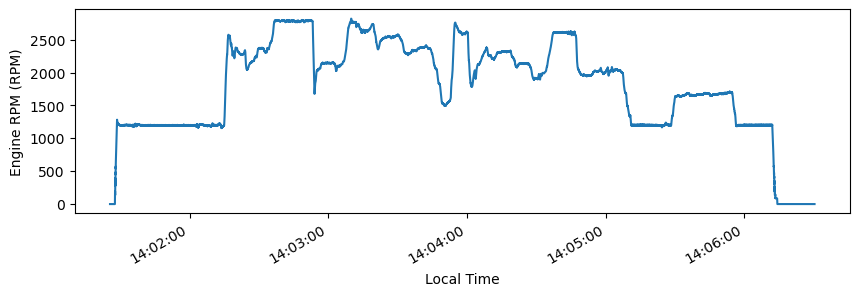

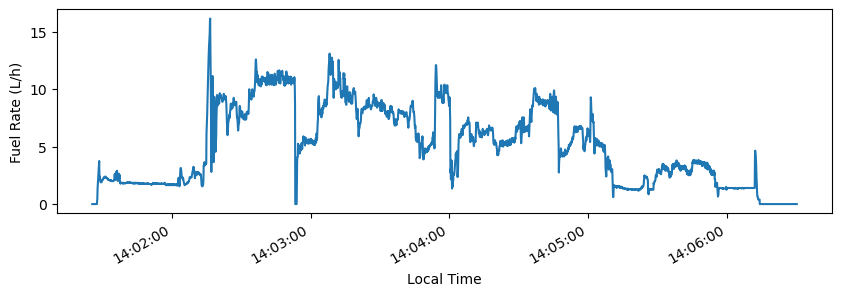

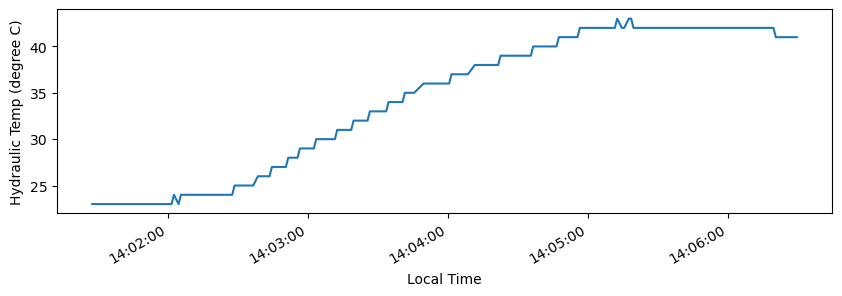

In [36]:
## Iterate over the PGN definitions dictionary (pgn). "d" is the nested dictionary
## containing the bytes range of each signal, the data offset, resultion, name and 
## units of its corresponding signal.

for pgn, d in pgns.items():
    
    ## Print the PGN we are working on
    print('Working on PGN {}'.format(pgn))
    ## Extract the data of the PGN we are interested
    log_f = can_log[can_log['pgn'] == pgn]
    
    ## Convert payloads in hex to binary digits
    bins = log_f['payload'].apply(lambda x: hex2bin(x))
    
    ## Create an auxiliary dataframe
    bins_col = pd.DataFrame()
    print('Mapping ...')
    
    ## Map binary digits to a column into an auxiliary dataframe
    for n in range(64):
        bins_col[n] = bins.apply(lambda x: map2col(n, x))
    print('Done')
    
    ## Print the table with the digits mapped to columns to verify 
    ## correctness in our operation
    print(bins_col)
    
    ## Parse digits in string form to integer numbers 
    bins_col = bins_col.astype(int)
    
    ## Parse PGN by selecting the bytes of the signal, and then merging the signals
    s_dec = bins_col[d['bytes']].astype(str).apply(lambda x: int((''.join(x)), 2) * d['resolution'] + d['offset'], axis=1)
    
    ## Plot the resulting data as a time series plot
    fig, ax = plt.subplots(figsize=(10,3))
    ax.plot(s_dec.index, s_dec.values)
    fig.autofmt_xdate()
    ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M:%S"))
    ax.set_xlabel('Local Time')
    ax.set_ylabel('{} ({})'.format(d['name'], d['unit']))


That's all folks! I hope you had fun doing some data wrangling with data from real sensors. If you have any questions, or found any oversight in this workshop, please send me an email (fcastibl@purdue.edu) and I can help you with any questions. Also, corrections are always greatly appreciated!